# Fashion MNIST deep learning experiments

### Notebook showing a from scratch implementation of a single layer neural network applied to the Fashion MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#### 1. Importing and preprocessing the Fashion MNIST data

In [5]:
def one_hot_encode(y):
    """
    One-hot encodes input vector y

    Parameters
    ----------
    y : np.array
        Vector to be one-hot encoded

    Returns
    -------
    y_enc : np.array
        One-hot encoding of vector y

    """
    N = y.shape[0]
    y.reshape(N,1)
    values_to_encode = np.unique(y)
    size = len(values_to_encode) # number of values to be encoded
    
    y_enc = np.zeros((N, size))
    for i in range(N):
        y_enc[i, int(y[i])] = 1
    
    return y_enc

In [21]:
def load_and_preprocess():
    """
    Loads training and test data from csv files and stores them in appropriate
    numpy arrays

    Parameters
    ----------
    train_file_path : string
        Name of file within current directory containing training data
    test_file_path : string
        Name of file within current directory containing test data

    Returns
    -------
    images_train : np.array
        Training data images in array of size (N_train, n_px * n_px) where
        N_train is number of training examples and n_px is pixel size of
        images (assuming square images)
    labels_train : np.array
        One-hot encoding of the labels corresponding to training data images.
        Of size (N_train, 10) (10 as this is how many unique values were encoded)
    images_test : np.array
        Training data images in array of size (N_test, n_px * n_px) where
        N_test is number of training examples
    labels_test : np.array
        One-hot encoding of the labels corresponding to test data images.
        Of size (N_test, 10)

    """
    # Load data
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (train_images, train_labels), (val_images, val_labels) = fashion_mnist.load_data()
    
    # Normalize and reshape data
    # Images are currently (N,28,28), we want (784,N)
    N_train = train_images.shape[0]
    N_val = val_images.shape[0]
    nx = train_images.shape[1]
    train_images = train_images.reshape((N_train, nx*nx)).T / 255
    val_images = val_images.reshape((N_val, nx*nx)).T / 255
    
    # One-hot encode the label data (originally of size (N,))
    train_labels_encoded = one_hot_encode(train_labels)
    val_labels_encoded = one_hot_encode(val_labels)
    
    print("Dataset loaded successfully and preprocessed!")
    
    return train_images, train_labels_encoded, val_images, val_labels_encoded, train_labels.reshape((N_train,1)), val_labels.reshape((N_val,1))

In [22]:
images_train, labels_train, images_val, labels_val, labels_train_orig, labels_val_orig = load_and_preprocess()

Dataset loaded successfully and preprocessed!


Let's check all the sizes are as we need them.

In [23]:
print("Training images has the shape: " + str(images_train.shape))
print("Training labels has the shape: " + str(labels_train.shape))
print("Training labels (before encoding) has the shape: " + str(labels_train_orig.shape))
print("Validation images has the shape: " + str(images_val.shape))
print("Validation labels has the shape: " + str(labels_val.shape))
print("Number of training examples: " + str(images_train.shape[1]))
print("Number of val examples: " + str(images_val.shape[1]))

print("Original training labels: ")
print(labels_train_orig)
print("Encoded training labels: ")
print(labels_train)

Training images has the shape: (784, 60000)
Training labels has the shape: (60000, 10)
Training labels (before encoding) has the shape: (60000, 1)
Validation images has the shape: (784, 10000)
Validation labels has the shape: (10000, 10)
Number of training examples: 60000
Number of val examples: 10000
Original training labels: 
[[9]
 [0]
 [0]
 ...
 [3]
 [0]
 [5]]
Encoded training labels: 
[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


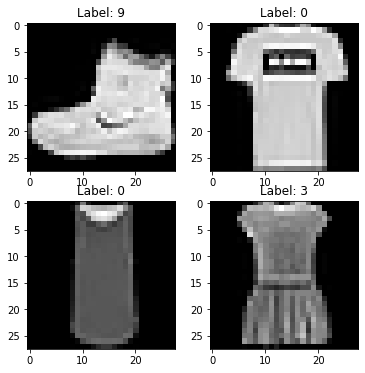

In [24]:
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%labels_train_orig[i])
    plt.imshow(images_train[:,i].reshape([28,28]),cmap='gray');

Define a function to initial the weights and bias of the neurons.

In [25]:
def initialize_parameters(n_w, n_out):
    """
    Initialize w parameter vector and bias with small random values

    Parameters
    ----------
    n_w : int
        number of w paramters to be initialized in w vector
        equal to to the number of input features, n_px*n_px

    Returns
    -------
    w : np.array
        vector of weights initialized with small random values
        of size (n_w, 1)
    b : float
        small randomly initialized bias

    """
    
    w = np.random.rand(n_w, n_out) * np.sqrt(1/n_w)
    b = np.zeros((1, n_out))
    
    return w, b

In [26]:
def sigmoid(x):
    
    s = 1 / (1 + np.exp(-x))
    
    return s

Define a function which will calculate the current prediction based on the current parameters (W and b) and then use gradient descent to improve the parameters.

In [27]:
def update_weights(w, b, x, d, labels_orig, alpha):
    """
    Update the values of weights and bias according to
    the value of difference between computed outputs
    and desired ouputs

    Parameters
    ----------
    w : np.array
        vector of weights of size (n_px*n_px, 1)
    b : float
        bias
    x : np.array
        training data of size (n_px*n_px, N)
    d : np.array
        desired outputs for training data of size
        (N, 1)
    N : int
        number of examples

    Returns
    -------
    w_new : np.array
        updated value of weights
    b_new : float
        updated value of bias
    error : float
        total error of dataset

    """
    N = x.shape[1]
    y = np.reshape(sigmoid(np.dot(x.T, w) + b), (d.shape))
    y_pred = np.reshape(np.argmax(y, axis = 1), labels_orig.shape)
    diff = d - y
    
    pc_error = float(np.sum(y_pred != labels_orig)) / N * 100
    pc_accuracy = float(np.sum(y_pred == labels_orig)) / N * 100
    
    # Update weights
    dw = np.dot(x, diff)
    db = np.sum(diff, axis = 0, keepdims=True)

    w_new = w + (alpha * dw)
    b_new = b + (alpha * db)
    
    
    return w_new, b_new, pc_error, pc_accuracy

Define the model which will iterate to continually improve the parameters.

In [28]:
def single_perceptron_model_train(images_train, labels_train, labels_train_orig, alpha = 0.0001, num_iter = 300):
    """
    Train a single perceptron model

    Parameters
    ----------
    images_train : np.array
        greyscale (0s and 1s) image matrix 
        of size (N,n_px,n_px)
    labels_train : np.array
        DESCRIPTION.
    alpha : float, optional
        learning rate The default is 0.1.
    acceptable_error : float, optional
        the maximum accpetable percentage error before 
        learning is stopped. The default is 0.

    Returns
    -------
    w : np.array
        final trained values of weights
    b : float
        final trained value of bias
    pc_error : 
        percentage error achieved once training has been completed

    """
    x = images_train
    N = x.shape[1] # numnber of training examples
    d = labels_train
    w, b = initialize_parameters(x.shape[0], labels_train.shape[1])
    accuracy_log = np.array([])
    
    print("Training has started...")
    
    for i in range(1, num_iter+1):
        w, b, pc_error, pc_accuracy = update_weights(w, b, x, d, labels_train_orig, alpha)
        accuracy_log = np.append(accuracy_log, pc_accuracy)
        if i % 10 == 0:
            print("Interation " + str(i) + ": % Error on training data = " + str(pc_error))
            print("% accuracy on training data = " + str(pc_accuracy))
    
    print("\n% error on training data: " + str(pc_error))
    print("% accuracy on training data = " + str(pc_accuracy))
    
    return w, b, pc_error, pc_accuracy, accuracy_log

Define a function that will generate a prediction on the validation set using the trained parameters.

In [35]:
def single_perceptron_model_predict(images_val, labels_val, labels_orig, w, b):
    """
    Get prediction on test data

    Parameters
    ----------
    images_test : TYPE
        DESCRIPTION.
    labels_test : TYPE
        DESCRIPTION.
    w : TYPE
        DESCRIPTION.
    b : TYPE
        DESCRIPTION.

    Returns
    -------
    y_pred : TYPE
        DESCRIPTION.
    pc_error : TYPE
        DESCRIPTION.

    """
    x = images_val
    N = x.shape[1] # numnber of test examples
    d = labels_val
    
    # Compute prediction and error
    y = np.reshape(sigmoid(np.dot(x.T, w) + b), d.shape)
    y_pred = np.reshape(np.argmax(y, axis = 1), labels_orig.shape)
    diff =  d - y_pred
    pc_error = float(np.sum(y_pred != labels_orig)) / N * 100
    pc_accuracy = float(np.sum(y_pred == labels_orig)) / N * 100
    print("% error on val data: " + str(pc_error))
    print("% accuracy on val data: " + str(pc_accuracy))
    
    return y_pred, pc_error, pc_accuracy

In [36]:
# Main
    
# Train model
w, b, pc_error_train, pc_accuracy_train, train_acc_log = single_perceptron_model_train(images_train, labels_train, labels_train_orig)
# Get predictions on test data
y_pred, pc_error_val, pc_accuracy_val = single_perceptron_model_predict(images_val, labels_val, labels_val_orig, w, b)

Training has started...


C:\Users\Jason\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Interation 10: % Error on training data = 58.245000000000005
% accuracy on training data = 41.754999999999995
Interation 20: % Error on training data = 37.31
% accuracy on training data = 62.69
Interation 30: % Error on training data = 31.630000000000003
% accuracy on training data = 68.37
Interation 40: % Error on training data = 35.14833333333333
% accuracy on training data = 64.85166666666666
Interation 50: % Error on training data = 26.543333333333337
% accuracy on training data = 73.45666666666666
Interation 60: % Error on training data = 39.78333333333333
% accuracy on training data = 60.21666666666666
Interation 70: % Error on training data = 36.42666666666667
% accuracy on training data = 63.57333333333334
Interation 80: % Error on training data = 32.446666666666665
% accuracy on training data = 67.55333333333333
Interation 90: % Error on training data = 30.961666666666666
% accuracy on training data = 69.03833333333334
Interation 100: % Error on training data = 25.161666666666

In [37]:
print("Validation labels: ")
print(labels_val_orig[0:30,0])
print("Predictions: ")
print(y_pred[0:30,0])

Validation labels: 
[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3]
Predictions: 
[9 8 1 1 6 1 4 6 5 7 1 5 8 3 8 1 8 8 8 0 8 7 7 7 1 8 6 3 9 3]


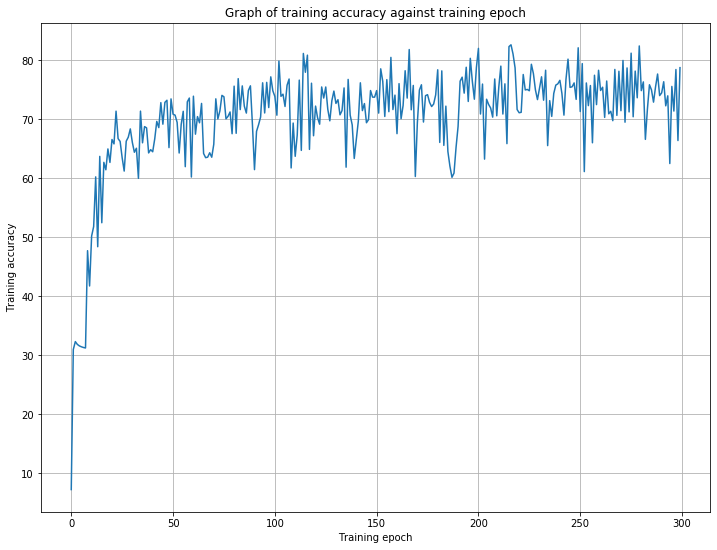

In [38]:
plt.figure(figsize=(12,9))

plt.plot(train_acc_log)

plt.title("Graph of training accuracy against training epoch")
plt.xlabel("Training epoch")
plt.ylabel("Training accuracy")
plt.grid(True)

plt.show()